In [1]:
import import_ipynb

import env_setup
import datasets
import lstm_predictor

import time
import torch
import torch.nn as nn
import torch.optim as optim
from music21 import instrument as m21instrument
from torch.utils.tensorboard import SummaryWriter
from fastprogress.fastprogress import master_bar, progress_bar

importing Jupyter notebook from env_setup.ipynb
importing Jupyter notebook from datasets.ipynb
importing Jupyter notebook from lstm_predictor.ipynb


In [2]:
''
def train(model, trainloader, resolution, optimizer, loss_fn, batch_size=1, num_epochs=5):
        writer = SummaryWriter()

        print("[Train Starting]")

        s_time = time.time()

        mb = master_bar(range(1, num_epochs+1))
        # mb.names = ['Loss', 'Beat Comparisons']

        # Beat comparison counter
        n_comparisons = 0
        comparison_index = 0

        train_loss = []

        #
        #   EPOCH ITERATION
        #
        for epoch_index in mb:

            count = 0
            training_loss = 0.0

            # Amount of comparison blocks in the DL
            train_iterator = iter(trainloader)
            n_comparisons = len(train_iterator)
            # print(f'[Train Iterator Length] {n_comparisons}')

            # print(f'Input data shape: {input_data.shape}')
            # print(f'Target data shape: {target_data.shape}')
            # print(f'Target data: {target_data}')

            # Initialize hidden and cells
            (hidden, cell) = model.init_hidden(batch_size)

            #
            #   BEAT COMPARISON ITERATION
            #
            for comparison_index in progress_bar(range(n_comparisons), parent=mb):

                # Add to total comparisons
                # comparison_index += prev_n_comparisons

                # print(f'\n[Comparison #{comparison_index + 1}]\n')

                sample = next(train_iterator) # (2, 16, 88)

                # Generate predictions
                input_seq = sample[0].to(model.device) # (1, 16, 88)
                target_seq = sample[1].to(model.device) # (1, 16, 88)

                # pprint.pprint(input_seq)
                # pprint.pprint(target_seq)

                # print(f'\t[Input Seq Shape] {input_seq.shape}')
                # pprint.pprint(input_seq)

                output_seq, (hidden, cell) = model(input_seq, hidden, cell)

                # print(output_seq)

                # print('\t[Output Seq Shape] ', output_seq.shape)
                # pprint.pprint(output_seq)

                # output_seq = self.fc(output_seq[:, -1, :])
                # print('b', output_seq.shape)
                # output_seq = self.sigmoid(output_seq)
                # print('c', output_seq.shape)

                # print(f'Output seq shape: {output_seq.shape}')
                # print('Target seq shape:', target_seq.shape)

                # Compute the loss and backpropag

                loss_step = loss_fn(output_seq, torch.squeeze(target_seq))

                # print(f'\t[Loss step] {loss_step}')

                hidden = hidden.detach()
                cell = cell.detach()

                count += 1

                # Backpropagate and compute gradients
                loss_step.backward()
                # Update net weights
                optimizer.step()
                # Clear gradients from the iteration
                optimizer.zero_grad()

                # Update loss accumulator
                training_loss += loss_step.item()

                mb.child.comment = f'[Loss step {loss_step:.8f}]'

            # Scale loss accumulator
            # training_loss /= len(dataloader.dataset)
            training_loss /= len(train_iterator)

            writer.add_scalar("Loss/train", training_loss, epoch_index)

            train_loss.append(training_loss)
            # model.plot_loss_update(epoch_index, num_epochs, mb, training_loss)
            mb.main_bar.comment = f'[Epoch {epoch_index} | Loss {training_loss:.8f}]'
            print(f'[Epoch {epoch_index} | Loss {training_loss:.8f}]')
            model.plot_loss_update(epoch_index, num_epochs, mb, train_loss)

        writer.flush()
        writer.close()

        print(f'[Finished training with Loss {training_loss:.8f} (took {time.time() - s_time} seconds)]')


= MODELO = 

LSTM(88, 128, num_layers=4, batch_first=True, bidirectional=True)


Linear(in_features=256, out_features=88, bias=False)

Dataset length: 1 songs.
[Train Starting]


[Epoch 1 | Loss 0.69312577]


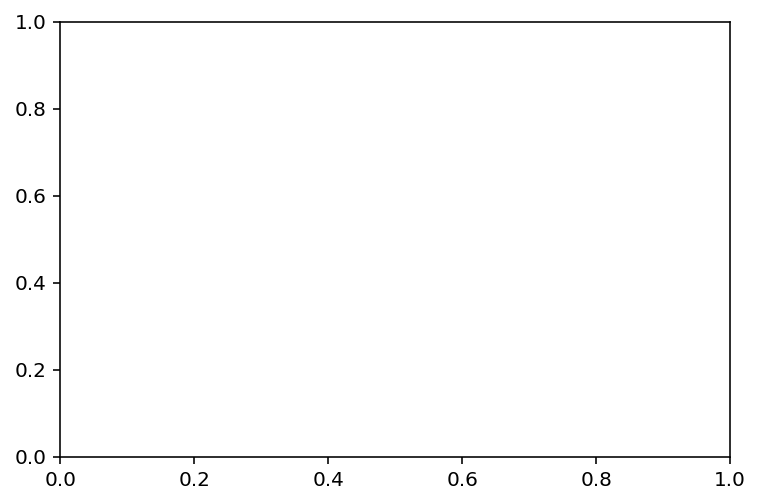

[Epoch 2 | Loss 0.69063325]
[Epoch 3 | Loss 0.68812565]
[Epoch 4 | Loss 0.68554423]
[Epoch 5 | Loss 0.68281697]
[Epoch 6 | Loss 0.67987393]
[Epoch 7 | Loss 0.67665617]
[Epoch 8 | Loss 0.67311099]
[Epoch 9 | Loss 0.66914505]
[Epoch 10 | Loss 0.66468255]
[Epoch 11 | Loss 0.65959902]
[Epoch 12 | Loss 0.65373674]
[Epoch 13 | Loss 0.64694305]
[Epoch 14 | Loss 0.63902747]
[Epoch 15 | Loss 0.62974698]
[Epoch 16 | Loss 0.61883846]
[Epoch 17 | Loss 0.60598969]
[Epoch 18 | Loss 0.59082895]
[Epoch 19 | Loss 0.57296164]
[Epoch 20 | Loss 0.55197643]
[Epoch 21 | Loss 0.52749721]
[Epoch 22 | Loss 0.49925788]
[Epoch 23 | Loss 0.46730455]
[Epoch 24 | Loss 0.43202339]
[Epoch 25 | Loss 0.39422387]
[Epoch 26 | Loss 0.35509014]
[Epoch 27 | Loss 0.31609960]
[Epoch 28 | Loss 0.27873178]
[Epoch 29 | Loss 0.24422665]
[Epoch 30 | Loss 0.21343002]
[Epoch 31 | Loss 0.18669825]
[Epoch 32 | Loss 0.16396845]
[Epoch 33 | Loss 0.14490876]
[Epoch 34 | Loss 0.12906191]
[Epoch 35 | Loss 0.11592437]
[Epoch 36 | Loss 0.105

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Data Settings
path = 'C_major_scale'
resolution = 16
keyboard_size = 88

# Model Parameters
input_size = 88
num_layers = 4
hidden_size = 128


# embedding = torch.load('Embeddings/test_embeddings.pkl')

# model = lstm_predictor.PerformanceLSTM(device, hidden_size=36)
model = lstm_predictor.PerformanceLSTM(
                                       # embedding,
                                       input_size,
                                       hidden_size,
                                       num_layers,
                                       device)


# test
pianoDataset = datasets.InstrumentDataset(path, 'Piano', keyboard_size)
pianoDataLoader = datasets.DataLoader(pianoDataset, batch_size=1, shuffle=True)
n_songs = len(pianoDataset)
print(f'Dataset length: {n_songs} songs.')

# print(pianoDataset[0])


for i, song in enumerate(pianoDataLoader):

    # Clause guard for empty instrument in song
    if len(song) == 0:
        continue

    mhe, velocities = song
    mhe = mhe[0]
    velocities = velocities[0]

    # print(type(song), '\n' ,len(song), song)
    # mhe_training_samples = datasets.TrainingSamples(mhe, resolution)
    training_samples = datasets.TrainingSamples(velocities, resolution)

    # DL depth = 1
    training_dl1 = datasets.DataLoader(training_samples, batch_size=1, shuffle=False)

    # DL depth = 4
    # training_dl4 = datasets.DataLoader(training_samples, batch_size=4, shuffle=False)

    # print(len(training_dl1))
    # print(len(training_dl4))

    # for sample in training_dl1:
    #     print(sample[1].shape)


    lr = 3e-3 # Learning Rate
    # adam_optimizer = optim.Adam(model.parameters(), lr=lr)
    sgd_optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss() # Binary Cross Entropy
    n_epochs = 150 # Train 3 times in each song

    train(model, training_dl1, resolution, sgd_optimizer, loss_fn, batch_size=1, num_epochs=n_epochs)

    torch.save(model, f'Models/pop1_{n_songs}_songs_{n_epochs}_epochs.pkl')

    # (200, 16, 88) -> 200x(1, 16, 88)

    # for sample in training_dl11:
    #     model.train(training_dl1)

